In [1]:
import random
from tqdm import trange

import sys
import numpy as np
import scipy

import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn

source = "../source"
sys.path.append(source)


from data import seq_data
from preprocessing import OneHot
from compilation import Compiler, ScalarTracker, ActivationTracker
from data_analysis.automata import (
    to_automaton_history,
    reduce_automaton,
    to_automaton,
    has_all_transitions,
)
from visualization.animation import SliderAnimation
from visualization.activations import ActivationsAnimation
from visualization.automata import AutomatonAnimation, display_automata
from visualization.epochs import EpochAnimation
import simulate

from model import Model
import publication

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

torch.manual_seed(0)
random.seed(0)

GPU is available


In [2]:
save = False

In [3]:
## Load settings
settings = "rich"

(nonlinearity, gain, lr, P, L, n_epochs, max_seq_len) = (
    pd.read_csv("model settings/rnn.txt", sep=" ", header=0).loc[settings].to_numpy()
)
P, L, n_epochs, max_seq_len = int(P), int(L), int(n_epochs), int(max_seq_len)

In [4]:
gain = 0.000000001
n_epochs = 1000

In [5]:
# lr = 0.0002
# n_epochs = 5000

In [6]:
gain = 0.01
lr = 0.00025
n_epochs = 1500
max_seq_len = 10

In [ ]:
gain = 0.01
lr = 0.00015
n_epochs = 2000
max_seq_len = 10

In [8]:
## Generate data

# Define problem and data encoding
symbols = [0, 1]
encoding = OneHot(symbols)
problem = lambda seq: np.sum(seq) % 2  # XOR problem
# problem = lambda seq: (np.sum(seq) % 3) % 2

# Define sequence lengths for training and validation datasets
train_seq_lengths = list(range(1, max_seq_len + 1))
analysis_seq_lengths = train_seq_lengths
# analysis_seq_lengths = list(range(1, 8 + 1))
val_seq_length = 50
val_datapoints = 100

# Generate datasets
training_datasets = [
    seq_data(device, problem, encoding, seq_len=length) for length in train_seq_lengths
]
validation_datasets = [
    seq_data(
        device, problem, encoding, n_datapoints=val_datapoints, seq_len=val_seq_length
    )
]
analysis_data = [
    seq_data(device, problem, encoding, seq_len=length)
    for length in analysis_seq_lengths
]
tracked_datasets = validation_datasets + analysis_data + training_datasets

In [9]:
## Instantiate model
model = Model(
    encoding=encoding,
    input_size=2,
    output_size=2,
    hidden_dim=P,
    n_layers=L,
    device=device,
    nonlinearity=nonlinearity,
    gain=gain,
)

In [10]:
## Setup compiler
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True, weight_decay=0.00)
compiler = Compiler(model, criterion, optimizer)
initial_hidden = model.init_hidden(batch_size=1)[-1]
hidden_function = lambda inputs: model(inputs)[1][-1]
output_function = lambda inputs: model(inputs)[0]
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        encoding,
        hidden_function,
        analysis_data,
        initial=lambda: initial_hidden,
    ),
    "output": ActivationTracker(encoding, output_function, analysis_data),
}

In [21]:
## Training run
compiler.training_run(
    training_datasets,
    n_epochs=n_epochs,
    batch_size=128,
)

Training:   8%|▊         | 137/1750 [02:44<32:18,  1.20s/steps, train_loss=0.00006, val_loss=0.05375]


KeyboardInterrupt: 

In [12]:
## ON TRANSFORMER TEST BEHAVIOUR ON ARBITRAY LONG RANGE SEQUENCE

In [22]:
## Visualize automaton dynamics

# Filter and process data for visualization
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "(Dataset <10) "
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

epochs = list(set(data_hid.index.get_level_values("Epoch")))
epochs.sort()

std = float(np.linalg.norm(data_hid.std()))
n_points = len(data_hid.query("Epoch == 0"))

automaton_history = to_automaton_history(data_hid, data_output, merge_distance=1 * std)
loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
n_states = np.array([len(automaton.states) for automaton in automaton_history])
is_finite = np.array([automaton.is_finite() for automaton in automaton_history])

Computing automata: 100%|██████████| 1887/1887 [07:49<00:00,  4.02it/s]


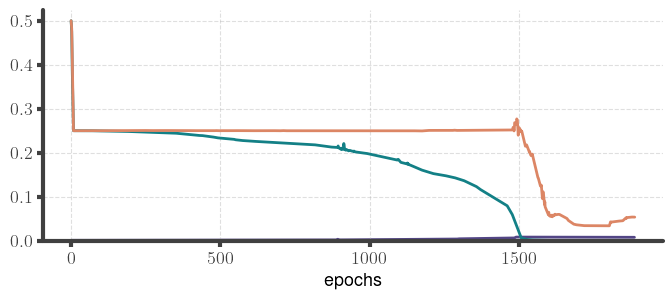

In [25]:
n_datapoints = sum(len(dataset) for dataset in analysis_data)

publication.set_color_mixed()
plt.figure(figsize=(8, 3))
plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
# plt.plot(n_states / n_datapoints, label="Number of states", zorder=0, color="0.5")
plt.plot(n_states / n_datapoints, label="Number of states", zorder=0)
# plt.plot(n_exit / n_datapoints)
plt.xlabel("epochs")
plt.ylim(0)
# plt.legend()
if save:
    publication.plt_show(save_path=f"plots/automaton_dynamics/{settings}_loss")
else:
    publication.plt_show()

In [15]:
stop

NameError: name 'stop' is not defined

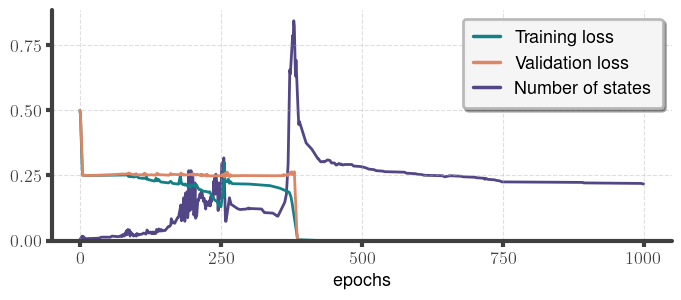

In [ ]:
n_datapoints = sum(len(dataset) for dataset in analysis_data)

publication.set_color_mixed()
plt.figure(figsize=(8, 3))
plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
# plt.plot(n_states / n_datapoints, label="Number of states", zorder=0, color="0.5")
plt.plot(n_states / n_datapoints, label="Number of states", zorder=0)
# plt.plot(n_exit / n_datapoints)
plt.xlabel("epochs")
plt.ylim(0)
plt.legend()
if save:
    publication.plt_show(save_path=f"plots/automaton_dynamics/{settings}_loss")
else:
    publication.plt_show()

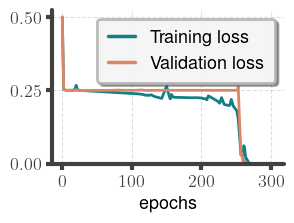

In [ ]:
n_datapoints = sum(len(dataset) for dataset in training_datasets)

publication.set_color_mixed()
plt.figure(figsize=(3, 2))
plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.xlabel("epochs")
plt.ylim(0)
plt.legend()
if save:
    publication.plt_show(save_path=f"plots/automaton_dynamics/{settings}_loss_small")
else:
    publication.plt_show()

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:01<00:00, 381.60it/s]


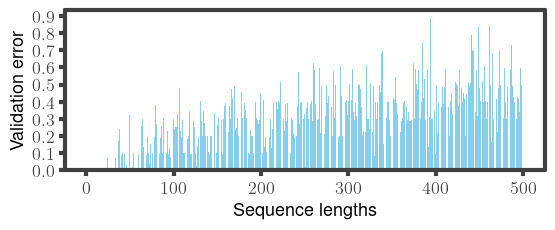

In [26]:
## Check for large sequence length generalization

# Evaluate model generalization for sequences of varying lengths
N = 500
val_data = []
for n in trange(1, N + 1):
    val_data.append(seq_data(device, problem, encoding, n_datapoints=10, seq_len=n))
val_err = compiler.validation(val_data).to_numpy()[:, 0]

# Visualize validation error for varying sequence lengths
publication.set_color_mixed()
fig = plt.figure(figsize=(6, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(np.arange(1, N + 1), val_err, color="skyblue")
ax.set_xlabel("Sequence lengths")
ax.set_ylabel("Validation error")
# ax.set_title("Model Generalization Across Sequence Lengths")
ax.set_yticks(np.arange(0, 1, 0.1))
if save:
    publication.pub_show(save_path=f"plots/automaton_dynamics/{settings}_validation")
else:
    publication.pub_show()

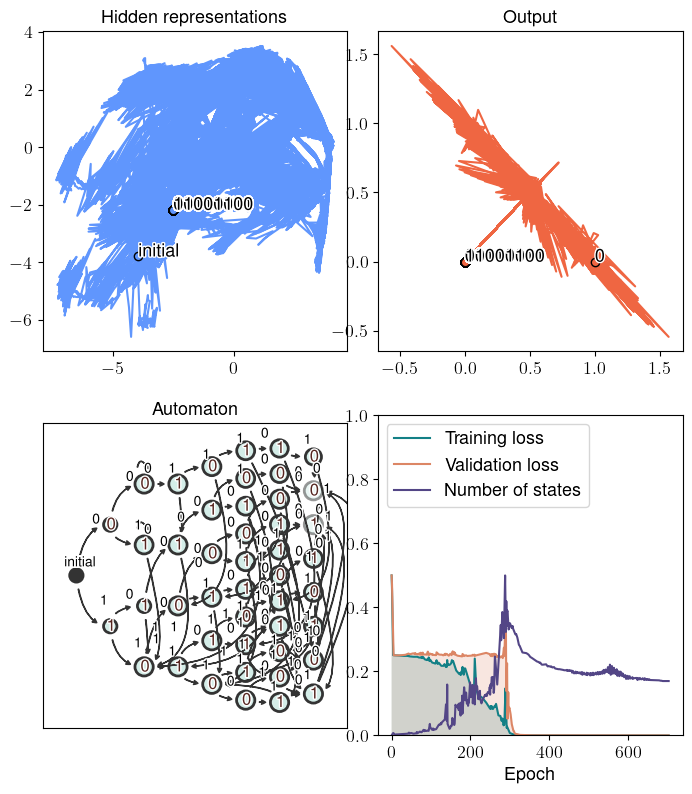

interactive(children=(SelectionSlider(description='Epoch:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…

In [ ]:
# Create animation
publication.set_color_mixed()
animation = SliderAnimation(
    {
        "Hidden representations": ActivationsAnimation(
            data_hid, transform="PCA", colors=[5] * n_points
        ),
        "Output": ActivationsAnimation(
            data_output,
            transform="none",
            fixed_points=encoding.encoding,
            colors=[6] * n_points,
        ),
        "Automaton": AutomatonAnimation(automaton_history, reduce_automata=True),
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                "Validation loss": val_loss,
            },
            unitless_graphs={
                "Number of states": n_states,
            },
            y_bounds=(0, 1),
        ),
    },
    parameters=epochs,
    parameter_name="Epoch",
    fig_size=4,
)

# Optionally export the animation
if save:
    animation.to_gif(f"plots/automaton_dynamics_{settings}")

In [ ]:
# animation.to_gif(f"plots/automaton_dynamics_reduced_{settings}")

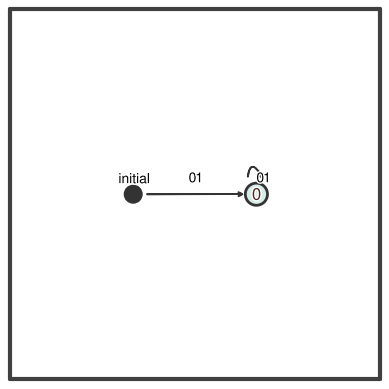

IndexError: list index out of range

In [ ]:
match settings:
    case "rich":
        epoch_choices = [0, 1000, 1999]
    case "intermediate":
        epoch_choices = [0, 350, 660, 1999]
    case "lazy":
        epoch_choices = [0, 1999]
    case "low_data":
        epoch_choices = [0, 600,1999]

for epoch in epoch_choices:
    automaton = automaton_history[epoch]
    display_automata(automaton)
    if save:
        publication.pub_show(
            save_path=f"plots/automaton_dynamics/{settings}_automaton_epoch_{epoch}"
        )
    else:
        publication.pub_show()

Computing automata: 100%|██████████| 1/1 [00:00<00:00, 25.12it/s]


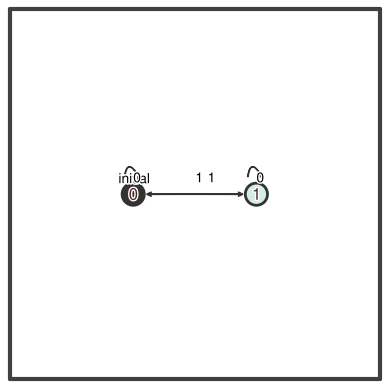

In [ ]:
automaton = to_automaton(
    hidden_function,
    output_function,
    initial_hidden,
    training_datasets,
    encoding,
    merge_distance_frac=0.1,
)
display_automata(reduce_automaton(automaton))
if save:
    publication.pub_show(
        save_path=f"plots/automaton_dynamics/{settings}_automaton_reduced"
    )
else:
    publication.pub_show()

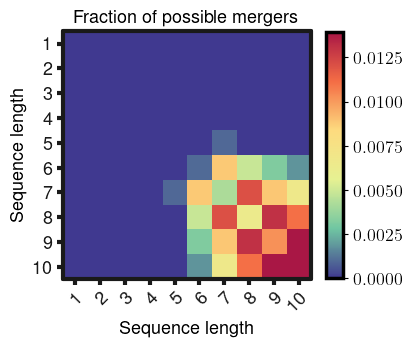

Total mergers: 11509
Total possible mergers: 1044484
Total unpredicted mergers: 0
Total predicted mergers: 11509


In [17]:
## Plot number of state mergers per sequence length pairs
last_epoch = int(data_hid.index.get_level_values("Epoch")[-1])
data_hid_analyze = data_hid.query("Dataset != -1").query(f"Epoch == {last_epoch}")
cutoff = 0.01 * std


merger_counts = np.zeros((len(training_datasets), len(training_datasets)))
total_mergers = 0
total_possible_mergers = 0
total_pred_mergers = 0
total_unpred_mergers = 0
for dataset_1, hid_1 in data_hid_analyze.groupby("Dataset"):
    h_1 = hid_1.to_numpy()
    labels_1 = hid_1.index.get_level_values("Input").to_numpy()
    outputs_1 = [problem(list(map(int, x))) for x in labels_1]
    for dataset_2, hid_2 in data_hid_analyze.groupby("Dataset"):
        if dataset_1 == 0 and dataset_2 == 0:
            break
        h_2 = hid_2.to_numpy()
        labels_2 = hid_2.index.get_level_values("Input").to_numpy()
        outputs_2 = [problem(list(map(int, x))) for x in labels_2]
        H = scipy.spatial.distance_matrix(h_1, h_2)
        mergers = H < cutoff
        possible_mergers = np.array(
            [[y_1 == y_2 for y_2 in outputs_2] for y_1 in outputs_1]
        )
        possible_mergers_sum = int(np.sum(possible_mergers) / 2)
        if dataset_1 == dataset_2:
            np.fill_diagonal(mergers, False)
            possible_mergers_sum -= len(hid_1) / 2
        count = int(np.sum(mergers) / 2)
        merger_counts[dataset_1, dataset_2] = count / possible_mergers_sum

        total_mergers += count
        total_possible_mergers += int(possible_mergers_sum)
        total_pred_mergers += int(np.sum(mergers * possible_mergers) / 2)
        total_unpred_mergers += int(np.sum(mergers * np.invert(possible_mergers)) / 2)

labels = np.arange(1, len(training_datasets) + 1)
plt.figure(figsize=(4, 4))
publication.set_color_gradient(0)
plt.imshow(merger_counts)
plt.xlabel("Sequence length")
plt.ylabel("Sequence length")
plt.title("Fraction of possible mergers")
publication.im_show(
    x_labels=labels,
    y_labels=labels,
    save_path=f"plots/{settings}_mergers",
)
print(f"Total mergers: {total_mergers}")
print(f"Total possible mergers: {total_possible_mergers}")
print(f"Total unpredicted mergers: {total_unpred_mergers}")
print(f"Total predicted mergers: {total_pred_mergers}")

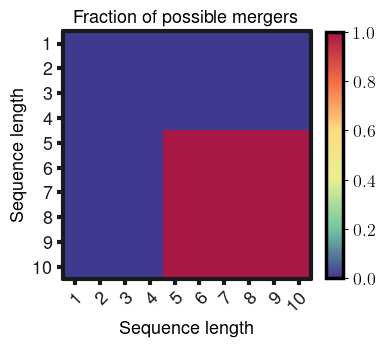

In [ ]:
max_len = training_datasets[-1][0][0].shape[0]
labels = np.arange(1, len(training_datasets) + 1)
plt.figure(figsize=(4, 4))
publication.set_color_gradient(0)
plt.imshow(np.minimum.outer(labels, labels) >= int(max_len / 2))
plt.xlabel("Sequence length")
plt.ylabel("Sequence length")
plt.title("Fraction of possible mergers")
publication.im_show(
    x_labels=labels,
    y_labels=labels,
)

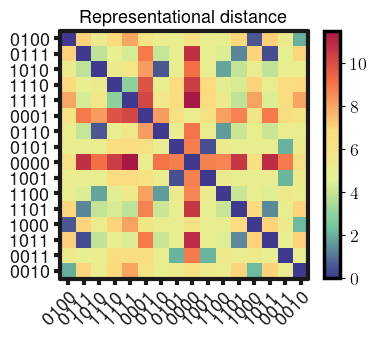

In [ ]:
last_epoch = int(data_hid.index.get_level_values("Epoch")[-1])
data_hid_analyze = data_hid.query("Dataset != -1 and Dataset == 3").query(
    f"Epoch == {last_epoch}"
)

h = data_hid_analyze.to_numpy()
H = scipy.spatial.distance_matrix(h, h)

labels = data_hid_analyze.index.get_level_values("Input").to_numpy()

plt.figure(figsize=(4, 4))
publication.set_color_gradient(0)
plt.imshow(H.astype(float))
plt.title("Representational distance")
publication.im_show(x_labels=labels, y_labels=labels)

In [29]:
## Plot trajectories

# Get data
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()

loss = compiler.trackers["loss"].get_trace().copy()
train_loss = loss.groupby("Epoch").mean()
train_loss = train_loss.to_numpy().ravel()

epochs = list(set(data_output.index.get_level_values("Epoch")))
epochs.sort()
# epochs = epochs[:3000]

In [252]:
# A_label_sim = ["010001110", "00", "0101101011", "0100", "0111"]
# B_label_sim = ["100010110", "11", "0101111100", "1000", "1011"]

N_pairs = 20

labels = set(data_hid.index.get_level_values("Input"))
labels.remove("initial")
labels = list(labels)
A_label_sim = random.sample(labels, N_pairs)
B_label_sim = []
for a in A_label_sim:
    while True:
        b = np.random.choice(labels)
        if (
            problem(list(map(int, a))) == problem(list(map(int, b)))
            and a != b
            and b not in B_label_sim
        ):
            B_label_sim.append(b)
            break

h_A_sim = [
    np.array(data.loc[epoch, :, A_label_sim])
    for epoch, data in data_hid.groupby("Epoch")
]
h_B_sim = [
    np.array(data.loc[epoch, :, B_label_sim])
    for epoch, data in data_hid.groupby("Epoch")
]
h2_sim = np.array(
    [np.sum((h_A_sim[epoch] - h_B_sim[epoch]) ** 2, axis=1) for epoch in epochs]
)

# A_label_diff = ["01011001", "010110011", "10"]
# B_label_diff = ["11011010", "110110101", "01"]

A_label_diff = random.sample(labels, N_pairs)
B_label_diff = []
for a in A_label_diff:
    while True:
        b = np.random.choice(labels)
        if (
            problem(list(map(int, a))) != problem(list(map(int, b)))
            and a != b
            and b not in B_label_diff
        ):
            B_label_diff.append(b)
            break

h_A_diff = [
    np.array(data.loc[epoch, :, A_label_diff])
    for epoch, data in data_hid.groupby("Epoch")
]
h_B_diff = [
    np.array(data.loc[epoch, :, B_label_diff])
    for epoch, data in data_hid.groupby("Epoch")
]
h2_diff = np.array(
    [np.sum((h_A_diff[epoch] - h_B_diff[epoch]) ** 2, axis=1) for epoch in epochs]
)

t = np.linspace(0, len(epochs), len(epochs))

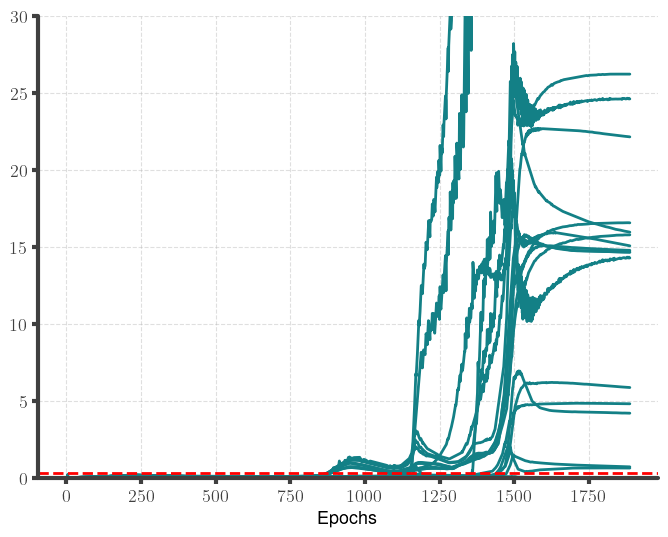

In [ ]:
## Plot trajectories
traj_path = "plots/2_points/trajectories/"

publication.set_color_mixed()
figsize = (8, 6)
fig, ax = plt.subplots(figsize=figsize)
for k, h in enumerate(np.transpose(h2_sim)):
    plt.gca().set_prop_cycle(None)
    ax.plot(t, h, label=f"{A_label_sim[k]} {B_label_sim[k]}")
for k, h in enumerate(np.transpose(h2_diff)):
    plt.gca().set_prop_cycle(None)
    publication.skip_colors(1)
    ax.plot(t, h, label=f"{A_label_diff[k]} {B_label_diff[k]}")
# ax.plot(t, 0.2 * n_states / max(n_states))
thresh = 0.1 * std
plt.axhline(thresh, linestyle="--", color="r")
# plt.ylim(0, 5 * thresh)
plt.ylim(0, 30)

# ax.legend()
plt.xlabel("Epochs")
if save:
    publication.plt_show(save_path=traj_path + "ode/" + settings + ".png")
else:
    publication.plt_show()

In [ ]:
# ## Plot trajectories

# # Get data
# data_hid = compiler.trackers["hidden"].get_trace()
# data_output = compiler.trackers["output"].get_trace()

# loss = compiler.trackers["loss"].get_trace().copy()
# train_loss = loss.groupby("Epoch").mean()
# train_loss = train_loss.to_numpy().ravel()

# epochs = list(set(data_output.index.get_level_values("Epoch")))
# epochs.sort()

# A_label = "00"
# B_label = "11"

# h_A = [
#     np.array(data.loc[epoch, :, A_label]) for epoch, data in data_hid.groupby("Epoch")
# ]
# h_B = [
#     np.array(data.loc[epoch, :, B_label]) for epoch, data in data_hid.groupby("Epoch")
# ]
# y_A = [
#     np.array(data.loc[epoch, :, A_label])
#     for epoch, data in data_output.groupby("Epoch")
# ]
# y_B = [
#     np.array(data.loc[epoch, :, B_label])
#     for epoch, data in data_output.groupby("Epoch")
# ]

# dx2 = 1
# y_true_A = encoding(problem(list(map(int, A_label))))
# y_true_B = encoding(problem(list(map(int, B_label))))
# dy2 = np.sum((y_true_B - y_true_A) ** 2)
# h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])
# y2 = np.array([np.sum((y_A[epoch] - y_B[epoch]) ** 2) for epoch in epochs])
# w = np.array(
#     [
#         y2[epoch] - np.dot(y_true_A - y_true_B, y_A[epoch] - y_B[epoch])
#         for epoch in epochs
#     ]
# )
# y0_mean = np.sum((0.5 * ((y_A[0] + y_B[0]) - (y_true_B + y_true_A))) ** 2)

# h0, y0, w0, dy = h2[0], y2[0], w[0], dy2


# ## Fit effective learning rates
# eta_h_opt, eta_y_opt, loss = simulate.optimize_eta(
#     h2, y2, w, dx2, dy2, guesses=np.logspace(-6, 2, 100)
# )

# sol = scipy.integrate.solve_ivp(
#     simulate.der,
#     [0, len(epochs)],
#     [h0, y0, w0],
#     args=(eta_h_opt, eta_y_opt, dx2, dy2),
#     dense_output=True,
# )
# t = np.linspace(0, len(epochs), len(epochs))
# z = sol.sol(t)

# # eta_y_mean_opt = simulate.optimize_eta_y_mean(z, train_loss, dy2, y0_mean)

# # loss_theory = simulate.loss(t, z, eta_y_mean_opt, dy2, y0_mean)


# traj_path = "plots/2_points/trajectories/"

# publication.set_color_mixed()
# figsize = (4, 3)

# # Plot 3-d dynamical system
# fig, ax = plt.subplots(figsize=figsize)
# plt.plot(t, z[0], linestyle="--")
# plt.plot(t, z[1], linestyle="--")
# plt.plot(t, z[2], linestyle="--")
# plt.gca().set_prop_cycle(None)
# ax.plot(t, h2, label="$||dh||^2$")
# ax.plot(t, y2, label="$||dy||^2$")
# ax.plot(t, w, label="$w$")
# ax.legend()
# plt.xlabel("Epochs")
# if save:
#     publication.plt_show(save_path=traj_path + "ode/" + settings + ".png")
# else:
#     publication.plt_show()

# # # Plot loss
# # fig, ax = plt.subplots(figsize=figsize)
# # plt.gca().set_prop_cycle(None)
# # ax.plot(0, 0)
# # ax.plot(0, 0)
# # ax.plot(t, loss_theory, label=r"loss (theory)", linestyle="--")
# # ax.plot(0, 0)
# # ax.plot(t, train_loss, label="loss", zorder=1)
# # ax.legend()
# # plt.ylim(0, 0.5)
# # plt.xlabel("Epochs")
# # if save:
# #     publication.plt_show(save_path=traj_path + "loss/" + settings + ".png")
# # else:
# #     publication.plt_show()

ValueError: shapes (2,) and (1,2) not aligned: 2 (dim 0) != 1 (dim 0)

In [ ]:
# import scipy
# from sklearn.cluster import AgglomerativeClustering
# from tqdm import tqdm

# import numpy as np

# data_hid = compiler.trackers["hidden"].get_trace()
# counts = []


# def count_states(H):
#     dist = scipy.spatial.distance_matrix(H, H)
#     fraction = 1 / dist
#     fraction = np.sum(np.nan_to_num(fraction, nan=0.0, posinf=0.0, neginf=0.0))
#     return fraction


# for n, h in tqdm(data_hid.groupby("Epoch")):
#     H = h.to_numpy()
#     counts.append(count_states(H))

# loss = compiler.trackers["loss"].get_trace()
# val_loss = loss.query("Dataset==0")[0].to_numpy()
# train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
# plt.plot(train_loss)
# plt.plot(val_loss)
# plt.plot(np.array(counts) / (H.shape[0]))
# plt.show()